Calculate inprop for central brain neurons on a signle neuron level. Optic lobe neurons are not included. Input from the optic lobe from the central brain is through the visual_projection neurons, which are preserved.  

This is the case except: some neurons with `super_class == 'optic'` still have synapses in the central brain. These synapses are kept. 
Input proportion is calculated with the total number of postsynapses in the entire brain (central + optic) as denominator, after modifying connectivity. 

The following synapses are removed: 
- postsynapses in fan-shaped body for **tangential neurons**; 
- postsynapses in elipsoid body for **PEN** neurons (since they are supposed to get input from protocerebral bridge); 
    - together with the ring neuron -> PEN connections (only in EB)
    - and ExR neuron -> PEN connections (only in EB)
- postsynapses in noduli for **PEN** neurons; 
- postsynapses in elipsoid body for **ring neurons** (since they are supposed to get input from outside the EB); 
    - together with EPG -> ring neuron connections (only in EB)
- postsynapses in the protocerebral bridge for **IbSpsP** neurons, and all Delta7 (intrinsic to the PB) -> IbSpsP connections. 
- postsynapses in the protocerebral bridge for **EPG** neurons (since they are supposed to get input from EB);
- ~~presynapses in the EB for **EPG**~~ - these are kept for now, for excitation from adjacent edges; 
- connections between **hDelta** neurosn and **EPG**: hDelta go to the FB, EPG does not. 
- postsynapses for **ExR4**, **ExR5** and **ExR6** in the axon-like compartments; 
- postsynapses for **LPsP** in EB; 
- postsynapses in all but PB for **PEG** since PEG has dendrites in the PB; 
- postsynapses in NO for **GLNO** since their axons are in NO; 

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy as sp
import matplotlib.pyplot as plt

# reading data

In [2]:
info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',
                   delimiter = '\t')
info.columns

C:\Users\44745\AppData\Local\Temp\ipykernel_128564\649695127.py:1: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  info = pd.read_csv('https://raw.githubusercontent.com/flyconnectome/flywire_annotations/main/supplemental_files/Supplemental_file1_neuron_annotations.tsv',


Index(['supervoxel_id', 'root_id', 'pos_x', 'pos_y', 'pos_z', 'soma_x',
       'soma_y', 'soma_z', 'nucleus_id', 'flow', 'super_class', 'cell_class',
       'cell_sub_class', 'cell_type', 'hemibrain_type', 'ito_lee_hemilineage',
       'hartenstein_hemilineage', 'morphology_group', 'top_nt', 'top_nt_conf',
       'known_nt', 'known_nt_source', 'side', 'nerve', 'vfb_id', 'fbbt_id',
       'status'],
      dtype='object')

In [3]:
info.super_class.value_counts(dropna = False)

super_class
optic                 77536
central               32388
sensory               16903
visual_projection      8053
ascending              2362
descending             1303
visual_centrifugal      524
motor                   106
endocrine                80
Name: count, dtype: int64

In [4]:
info.ito_lee_hemilineage.unique()

array(['SMPpv2_ventral', 'VLPl2_medial', nan, 'putative_primary',
       'VLPl&d1_lateral', 'VPNp2', 'VLPl1_or_VLPl5', 'VLPa1_lateral',
       'VPNl&d1_lateral', 'VLPl&p1_lateral', 'VLPd1', 'SMPad1',
       'VLPl&d1_dorsal', 'SMPad2', 'DILP__prim', 'DM1_CX_p', 'SMPad3',
       'SLPal5', 'SLPal2', 'LHa3', 'SLPa&l1_lateral', 'SLPav2', 'LHa1',
       'SIPa1_ventral', 'CREa2_medial', 'VLPp&l1_anterior', 'LHp3',
       'SLPp&v1_posterior', 'MBp4', 'DM1_CX_d2', 'DM1_antero_dorsal',
       'SLPpl1', 'DM3_CX_v', 'DM2_CX_p', 'SMPpm1', 'DM2_CX_d1',
       'DM2_CX_d2', 'primary', 'DM2_central', 'MBp1', 'DM3_CX_p',
       'DM1_CX_v', 'SLPad1_posterior', 'LHp2', 'VLPl2_posterior',
       'VPNp1_lateral', 'VPNd2', 'SLPav1_medial', 'LHa2', 'VPNd3',
       'VPNp1_medial', 'VPNp&v1_posterior', 'VPNd1', 'VPNp3',
       'VLPl4_anterior', 'MX3', 'VLPl&p2_lateral', 'MX12__prim',
       'MX0__prim', 'MD0__prim', 'LB19', 'LB3', 'LB0_anterior', 'FLAa3',
       'LB5', 'WEDa1', 'VLPd&p1_posterior', 'ALad1__prim

In [5]:
info["combined_type"] = info.cell_type
# fill the leftover nas with hemibrain_type
info.combined_type.fillna(info.hemibrain_type, inplace= True)
info.combined_type.value_counts()

combined_type
R1-6        8452
Dm3         2545
KCg-m       2190
T2a         1781
Tm3         1746
            ... 
OA-VUMa8       1
OA-VUMa7       1
AVLP458        1
PLP024         1
CB1880         1
Name: count, Length: 8451, dtype: int64

In [6]:
# fill the still leftover nas with root ids
info.combined_type.fillna(info.root_id.astype(str), inplace= True)

In [7]:
# make dictionaries to map between columns 
typedict = dict(zip(info.root_id, info.combined_type))
sidedict = dict(zip(info.root_id, info.side))
type_super_class_dict = dict(zip(info.combined_type, info.super_class))
type_class_dict = dict(zip(info.combined_type, info.cell_class)) 
type_sub_class_dict = dict(zip(info.combined_type, info.cell_sub_class))

In [8]:
# to make the matrix smaller, let's take visual projection neurons as visual input, and remove the optic lobe neurons
cb = info[~info.super_class.isin(['optic'])]
# filter out the visual sensory neurons, except for the ocellar ones
cb = cb[(cb.cell_class != 'visual') | (cb.cell_type == 'ocellar retinula cell')]
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,acetylcholine,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,acetylcholine,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,acetylcholine,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,acetylcholine,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,acetylcholine,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123502,79587599823629322,720575940618417409,130350,14001,3229,NaN,NaN,NaN,NaN,afferent,...,NaN,NaN,NaN,NaN,left,OCN,fw123599,FBbt_00004242,NaN,ocellar retinula cell
123503,79587599823608864,720575940628941553,130046,14747,3205,NaN,NaN,NaN,NaN,afferent,...,serotonin,0.734219,NaN,NaN,left,OCN,fw123600,FBbt_00004242,NaN,ocellar retinula cell
123504,79728680842360672,720575940612567258,132026,19096,3069,NaN,NaN,NaN,NaN,afferent,...,serotonin,0.729409,NaN,NaN,center,OCN,fw123601,FBbt_00004242,NaN,ocellar retinula cell
123505,79798912214529467,720575940630757750,133378,17839,3166,NaN,NaN,NaN,NaN,afferent,...,serotonin,0.544816,NaN,NaN,center,OCN,fw123602,FBbt_00004242,NaN,ocellar retinula cell


## read connectivity
Courtesy of Dr Sven Dorkenwald: https://zenodo.org/records/10676866

In [9]:
# this can take a minute or two 
from io import BytesIO
import requests

url = 'https://zenodo.org/records/10676866/files/proofread_connections_783.feather'

# Download the file
response = requests.get(url)

# Use the file content directly in Python
file_content = response.content

full_conn = pd.read_feather(BytesIO(file_content))
full_conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815


## get all central brain neurons

In [10]:
full_conn.neuropil.unique()

array(['AVLP_R', 'SLP_R', 'SMP_R', 'SMP_L', 'LAL_R', 'AL_L', 'SIP_R',
       'AVLP_L', 'AOTU_L', 'LA_R', 'MB_ML_R', 'CRE_L', 'GNG', 'CRE_R',
       'EB', 'PRW', 'MB_ML_L', 'AL_R', 'MB_VL_R', 'MB_VL_L', 'GA_L',
       'GA_R', 'AOTU_R', 'FLA_R', 'LAL_L', 'FLA_L', 'MB_PED_R', 'SAD',
       'AMMC_R', 'SIP_L', 'PVLP_R', 'MB_PED_L', 'UNASGD', 'AMMC_L',
       'LO_L', 'ME_R', 'LOP_L', 'LO_R', 'PLP_R', 'SCL_L', 'ME_L', 'LOP_R',
       'LH_L', 'VES_R', 'LH_R', 'MB_CA_L', 'IPS_L', 'SLP_L', 'PLP_L',
       'SPS_L', 'IPS_R', 'GOR_R', 'FB', 'SPS_R', 'PVLP_L', 'ICL_L',
       'SCL_R', 'ICL_R', 'ATL_R', 'IB_R', 'NO', 'AME_L', 'VES_L', 'WED_L',
       'MB_CA_R', 'WED_R', 'LA_L', 'ATL_L', 'EPA_R', 'PB', 'IB_L',
       'EPA_L', 'GOR_L', 'CAN_R', 'AME_R', 'OCG', 'CAN_L', 'BU_R', 'BU_L'],
      dtype=object)

In [11]:
# get connections in central brain neuropils, and those in 'UNASGD' 
conn_cb = full_conn[~full_conn.neuropil.isin(
    ['LO_L', 'LO_R', 'LOP_L', 'LOP_R', 'AME_L', 'AME_R', 'ME_L', 'ME_R', 'LA_L', 'LA_R'])]
conn_cb

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,0.272418,4.812546e-02,0.000472,0.000951
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,0.580512,8.166312e-04,0.000857,0.007278
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,0.001811,1.633383e-05,0.005870,0.011328
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,0.472987,9.134340e-03,0.086973,0.387136
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,0.000522,3.998458e-07,0.000103,0.000040
...,...,...,...,...,...,...,...,...,...,...
16847984,720575940627253510,720575940621326430,SMP_L,1,0.007995,0.983840,0.000792,9.907485e-04,0.000257,0.006124
16847990,720575940622010373,720575940634459290,VES_R,2,0.446577,0.407034,0.084707,1.664534e-03,0.007724,0.052293
16847991,720575940624054792,720575940634431935,ICL_L,5,0.012248,0.916746,0.017556,2.496850e-02,0.001025,0.027456
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,0.032063,1.844075e-03,0.028945,0.036396


In [12]:
# get ids that are not in 'cb' dataframe, and where the connections are not in 'UNASGD'
allids = set(np.unique(conn_cb.loc[conn_cb.neuropil != 'UNASGD', [
             'pre_pt_root_id', 'post_pt_root_id']].values))
diff = allids - set(cb.root_id)
# so it's an additional 800 neurons to add 
len(diff)

809

In [13]:
root_to_super_class = dict(zip(info.root_id, info.super_class))
root_to_type = dict(zip(info.root_id, info.cell_type))

# get connectivity of these neurons 
diff_conn = conn_cb[conn_cb.pre_pt_root_id.isin(diff) | conn_cb.post_pt_root_id.isin(diff)]
diff_conn.loc[:, ['pre_type']] = diff_conn.pre_pt_root_id.map(root_to_type)
diff_conn.loc[:, ['post_type']] = diff_conn.post_pt_root_id.map(root_to_type)
diff_conn.loc[:, ['pre_super_class']
              ] = diff_conn.pre_pt_root_id.map(root_to_super_class)
diff_conn.loc[:, ['post_super_class']
              ] = diff_conn.post_pt_root_id.map(root_to_super_class)
diff_conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_super_class,post_super_class
86611,720575940621670790,720575940633176204,PLP_L,1,0.000306,0.993034,0.000002,4.975129e-03,0.000001,0.001681,MTe51,NaN,visual_projection,optic
88523,720575940613890674,720575940624259720,PVLP_L,2,0.004933,0.086932,0.906161,1.757409e-07,0.001842,0.000133,cM08c,NaN,visual_centrifugal,optic
90386,720575940633176204,720575940624837048,LH_L,1,0.024881,0.093679,0.473516,1.536110e-02,0.015699,0.376865,NaN,NaN,optic,central
91872,720575940645418007,720575940635019927,OCG,5,0.400660,0.169005,0.403668,1.831193e-04,0.014017,0.012467,NaN,ocellar retinula cell,optic,sensory
98454,720575940618571494,720575940628430920,PLP_R,2,0.002897,0.907900,0.002614,1.550147e-03,0.000166,0.084873,NaN,NaN,optic,optic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838304,720575940624615753,720575940631834386,OCG,6,0.188025,0.017485,0.790925,7.519105e-05,0.001917,0.001573,NaN,ocellar retinula cell,optic,sensory
16841833,720575940627223751,720575940630884908,PVLP_R,1,0.486621,0.009556,0.486891,1.377353e-02,0.000998,0.002160,NaN,LC14b,central,optic
16842236,720575940616245446,720575940627874503,OCG,2,0.015192,0.494960,0.465144,5.185518e-04,0.021413,0.002774,OCC02a,NaN,visual_centrifugal,optic
16843067,720575940628908548,720575940622132545,PVLP_L,1,0.025738,0.949395,0.003534,6.734639e-03,0.000479,0.014118,NaN,cMLLP02,optic,visual_centrifugal


In [14]:
diff_conn[['pre_super_class', 'post_super_class']].value_counts()

pre_super_class     post_super_class  
optic               central               1514
                    visual_projection     1299
visual_projection   optic                 1009
visual_centrifugal  optic                  836
optic               optic                  560
                    visual_centrifugal     550
central             optic                  493
optic               sensory                318
sensory             optic                  191
optic               descending             138
ascending           optic                   36
optic               ascending               25
descending          optic                   24
Name: count, dtype: int64

In [15]:
# if these connections should be included 
diff_conn[(diff_conn.pre_super_class == 'optic') & (diff_conn.post_super_class ==
                                                'optic')].sort_values(by='syn_count', ascending=False)

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type,pre_super_class,post_super_class
2990852,720575940620225585,720575940626111502,PVLP_L,10,0.430330,0.107050,0.449835,0.005211,0.001385,0.006190,NaN,NaN,optic,optic
12860636,720575940620225585,720575940613493733,PVLP_L,6,0.633497,0.016446,0.345339,0.000871,0.000845,0.003003,NaN,MeMe_e11,optic,optic
8599313,720575940623138584,720575940636868983,PLP_L,6,0.008757,0.942742,0.021286,0.000415,0.004363,0.022436,NaN,CB3822,optic,optic
7295036,720575940621117781,720575940625952755,PLP_L,5,0.081740,0.698361,0.131705,0.017336,0.005980,0.064878,CB3833,NaN,optic,optic
2725702,720575940626707914,720575940632529219,PLP_L,5,0.030514,0.431662,0.020452,0.000136,0.217676,0.299560,NaN,CB3822,optic,optic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259006,720575940621784923,720575940624258857,PLP_L,1,0.012476,0.975805,0.001672,0.000681,0.000174,0.009192,CB3833,NaN,optic,optic
6216957,720575940661277313,720575940617910411,PLP_L,1,0.011221,0.923831,0.002786,0.001278,0.000589,0.060295,CB3833,CB3833,optic,optic
6192563,720575940625062891,720575940614124354,PLP_L,1,0.420484,0.162326,0.018916,0.223209,0.024200,0.150865,NaN,NaN,optic,optic
6047687,720575940617019442,720575940650935673,PLP_R,1,0.048410,0.698824,0.179066,0.032065,0.000882,0.040752,NaN,NaN,optic,optic


In [16]:
# check these neurons in neuroglancer 
print(','.join([str(x) for x in diff]))

720575940627202051,720575940607791113,720575940622833677,720575940626051086,720575940622229537,720575940621961257,720575940632137770,720575940631207980,720575940631306284,720575940626567216,720575940617019442,720575940616867894,720575940618147899,720575940640153661,720575940638976063,720575940610441284,720575940632850503,720575940628430920,720575940620968016,720575940620968021,720575940621101141,720575940640856152,720575940627523673,720575940617990237,720575940622366814,720575940635586655,720575940611838050,720575940623775843,720575940623917155,720575940637573221,720575940631783528,720575940646420590,720575940646058094,720575940622366836,720575940614918261,720575940649977977,720575940619880571,720575940619640955,720575940660617345,720575940623198344,720575940625651849,720575940617910411,720575940633176204,720575940615108754,720575940622037139,720575940615553170,720575940613986454,720575940635422871,720575940619927710,720575940638374051,720575940615295143,720575940628453544,720575940627

Since the neuropils are not defined super precisely, some connections in the optic lobe are still kept. Without looking in more detail, it is hard to remove those, while keeping 'optic' neurons with projections in the central brain. We'll update `cb` below to include these ~800 neurons, and use the total number of posynapses across the entire brain (central brain + optic lobes) for the denominator in normalised connectivity. 

In [17]:
cb = info[info.root_id.isin(cb.root_id) | info.root_id.isin(diff)]
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,acetylcholine,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,acetylcholine,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,acetylcholine,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,acetylcholine,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,acetylcholine,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,83038485720179477,720575940618571494,181000,56672,3032,181000.0,56672.0,3032.0,7667349.0,intrinsic,...,acetylcholine,0.909508,NaN,NaN,right,NaN,fw019880,NaN,NaN,720575940618571494
139251,81632416707449383,720575940633170572,160568,75600,4130,160568.0,75600.0,4130.0,6918265.0,intrinsic,...,acetylcholine,0.842339,NaN,NaN,right,NaN,fw002173,NaN,outlier_bio,CB3823
139252,81702991543049294,720575940650339961,161088,79280,3677,161088.0,79280.0,3677.0,6918344.0,intrinsic,...,acetylcholine,0.927558,NaN,NaN,right,NaN,fw010095,NaN,outlier_bio,CB3848
139253,75720205111813659,720575940619997854,74280,57640,3166,74280.0,57640.0,3166.0,1511338.0,intrinsic,...,acetylcholine,0.897331,NaN,NaN,left,NaN,fw046509,NaN,NaN,720575940619997854


# NT

In [18]:
cb.top_nt.value_counts(dropna = False)

top_nt
acetylcholine    28692
glutamate         9024
dopamine          5851
gaba              5823
serotonin         1782
NaN                146
octopamine          92
Name: count, dtype: int64

In [19]:
cb.known_nt.unique()

array([nan, 'acetylcholine', 'DILP2, DILP3, DILP5', 'glutamate',
       'glutamate, sparkly, proctolin, Nplp1',
       'dopamine, sparkly, Nplp1, amnesiac, CG43117, ion-transport peptide, nitric oxide',
       'gaba', 'acetylcholine, Nplp1, sNPF, sparkly',
       'glutamate, Dh44, allatostatin-c', 'dopamine',
       'acetylcholine, sNPF, sparkly', 'Dh44', 'octopamine',
       'acetylcholine, sparkly',
       'dopamine, amnesiac, sparkly, Nplp1, CG34136, sNPF', 'CCHa2R',
       'Drosulfakinin', 'gaba, myoinhibitory peptide',
       'dopamine, Nplp1, sNPF, sparkly, amnesiac, CG34136',
       'dopamine, amnesiac, sparkly, Dh44, CG34136, Nplp1',
       'allatostatin-a, glutamate', 'CCHa1, Dh44, glutamate',
       'dopamine, amnesiac, sparkly, pdf, Gpb5', 'Dh31',
       'acetylcholine, space blanket',
       'gaba, serotonin, sparkly, Nplp1, proctolin, orcokinin, eclosion hormone, CG34136',
       'serotonin', 'glycine, pdf', 'dopamine, nitric oxide',
       'glutamate, leucokinin', 'corazo

In [20]:
# known_nt takes priority 
cb['known_nt_simplified'] = cb.known_nt
# pattern matching: only keep if value contains 'glutamate', 'gaba', or 'acetylcholine'
cb.known_nt_simplified = cb.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
# note that if a value has multiple matches, only the first one is kept
# e.g. 'glutamate, gaba' will be simplified to 'glutamate'
cb.known_nt_simplified.value_counts(dropna = False)

# then use this column to replace values in top_nt column 
cb.top_nt = cb.known_nt_simplified.fillna(cb.top_nt)

C:\Users\44745\AppData\Local\Temp\ipykernel_128564\2051618523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb['known_nt_simplified'] = cb.known_nt
C:\Users\44745\AppData\Local\Temp\ipykernel_128564\2051618523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb.known_nt_simplified = cb.known_nt_simplified.str.extract('(glutamate|gaba|acetylcholine)', expand = False)
C:\Users\44745\AppData\Local\Temp\ipykernel_128564\2051618523.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of

C:\Users\44745\AppData\Local\Temp\ipykernel_128564\2070865634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb['top_nt'] = cb['top_nt'].fillna('unknown')


(array([9.348e+03, 5.180e+02, 0.000e+00, 5.200e+01, 0.000e+00, 1.900e+01,
        3.000e+00, 0.000e+00, 5.000e+00, 1.000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

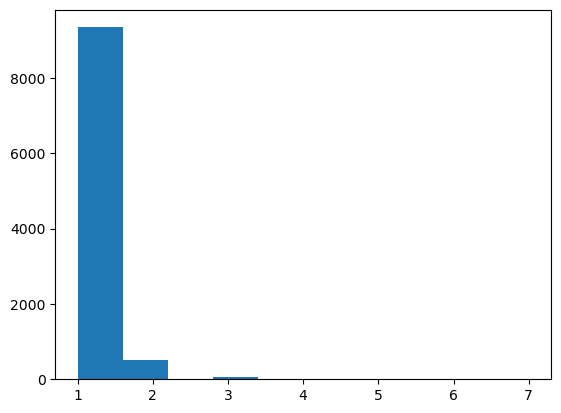

In [21]:
# first check consistency of NT within each type 
cb['top_nt'] = cb['top_nt'].fillna('unknown')
nt_count_per_type = cb.groupby('combined_type')['top_nt'].nunique()
plt.hist(nt_count_per_type)

In [22]:
# For those with different NT for each neuron, get the majority NT for each type
nt_conflict_types = nt_count_per_type[nt_count_per_type > 1].index

# Getting counts of top_nt for each combined_type
nt_conflict_type_counts = cb[cb.combined_type.isin(nt_conflict_types)].groupby(['combined_type', 'top_nt']).size()

# Convert the series to a DataFrame and reset index
nt_conflict_type_counts = nt_conflict_type_counts.reset_index(name='counts')

# Sort by combined_type and counts in descending order
nt_conflict_type_counts.sort_values(by=['combined_type', 'counts'], ascending=[True, False], inplace=True)

# Initialize dictionary with existing type-nt matching
type_nt = dict(zip(cb.combined_type, cb.top_nt))
# Initialize a list to keep track of types with equal top_nt counts
types_with_equal_top_nt_counts = []

# Custom function to handle ties, random selection, and record keeping
def select_random_nt_and_record_ties(df):
    max_count = df['counts'].max()
    top_nts = df[df['counts'] == max_count]
    if len(top_nts) > 1:  # If there are ties
        types_with_equal_top_nt_counts.append(df['combined_type'].iloc[0])  # Record the type with ties
        random_nt = np.random.choice(top_nts['top_nt'].values)
        while random_nt == 'unknown': 
            random_nt = np.random.choice(top_nts['top_nt'].values)
        return random_nt  # Random selection among ties
    else:
        return top_nts['top_nt'].values[0]

# Loop through each type to get the top_nt, handling ties appropriately
for atype in nt_conflict_types:
    type_df = nt_conflict_type_counts[nt_conflict_type_counts['combined_type'] == atype]
    top_nt = select_random_nt_and_record_ties(type_df)
    type_nt[atype] = top_nt

len(types_with_equal_top_nt_counts)

234

In [23]:
# the types without any known nt 
[atype for atype, nt in type_nt.items() if nt == 'unknown']

['720575940638707901',
 'DNge061',
 '720575940612376690',
 'ITP',
 '720575940626896145',
 '720575940622611917',
 '720575940624156391',
 '720575940632738259',
 '720575940621636988',
 '720575940610239608',
 '720575940623382711',
 '720575940612269283',
 'AN_GNG_204',
 'AN_GNG_124',
 '720575940614957115',
 '720575940626216720',
 '720575940621463699',
 '720575940606375772',
 '720575940610183154',
 '720575940617816661',
 '720575940635901274',
 '720575940612137895',
 '720575940621568490',
 '720575940619617919',
 '720575940628335611',
 '720575940633705560',
 '720575940637470627',
 '720575940639152117',
 '720575940638909429',
 '720575940614736699',
 '720575940611937967',
 '720575940613684274',
 '720575940625771780',
 '720575940619904380',
 '720575940630846125',
 '720575940624211202',
 '720575940611477229',
 '720575940628628055',
 '720575940618759078',
 '720575940629273130',
 '720575940618109460',
 '720575940611810001',
 '720575940628268226',
 '720575940620287820',
 '720575940623758669',
 '72057

In [24]:
# update the top_nt column to be consistent within each type 
cb.loc[:,['top_nt']] = cb.combined_type.map(type_nt)
cb

,supervoxel_id,root_id,pos_x,pos_y,pos_z,soma_x,soma_y,soma_z,nucleus_id,flow,...,top_nt_conf,known_nt,known_nt_source,side,nerve,vfb_id,fbbt_id,status,combined_type,known_nt_simplified
0,78112261444987077,720575940628857210,109306,50491,3960,104904.0,47464.0,5461.0,2453924.0,intrinsic,...,0.917977,NaN,NaN,left,NaN,fw138205,FBbt_20001935,NaN,PS180,NaN
1,82475466912542440,720575940626838909,172029,55635,1592,177472.0,56936.0,1429.0,7393349.0,intrinsic,...,0.645442,NaN,NaN,right,NaN,fw000001,NaN,NaN,CB0924,NaN
2,83038623024880664,720575940626046919,180632,58664,1925,180632.0,58664.0,1925.0,7415038.0,intrinsic,...,0.844781,NaN,NaN,right,NaN,fw000002,FBbt_20000538,NaN,AVLP429,NaN
3,79801523353604463,720575940630311383,133800,56063,1847,180728.0,61008.0,1630.0,7415013.0,intrinsic,...,0.760387,NaN,NaN,right,NaN,fw000003,FBbt_20000260,NaN,AVLP151,NaN
4,83038554439606237,720575940633370649,180496,57448,2989,180496.0,57448.0,2989.0,7415848.0,intrinsic,...,0.895458,NaN,NaN,right,NaN,fw000004,FBbt_00051248,NaN,LC27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,83038485720179477,720575940618571494,181000,56672,3032,181000.0,56672.0,3032.0,7667349.0,intrinsic,...,0.909508,NaN,NaN,right,NaN,fw019880,NaN,NaN,720575940618571494,NaN
139251,81632416707449383,720575940633170572,160568,75600,4130,160568.0,75600.0,4130.0,6918265.0,intrinsic,...,0.842339,NaN,NaN,right,NaN,fw002173,NaN,outlier_bio,CB3823,NaN
139252,81702991543049294,720575940650339961,161088,79280,3677,161088.0,79280.0,3677.0,6918344.0,intrinsic,...,0.927558,NaN,NaN,right,NaN,fw010095,NaN,outlier_bio,CB3848,NaN
139253,75720205111813659,720575940619997854,74280,57640,3166,74280.0,57640.0,3166.0,1511338.0,intrinsic,...,0.897331,NaN,NaN,left,NaN,fw046509,NaN,NaN,720575940619997854,NaN


In [25]:
# for now regarding everything (ACh, Glu, GABA, Dopamine, Serotonine, ??) except for Glu and GABA to be excitatory
# first make a dictionary 
nt_value = {'acetylcholine': 1, 
           'glutamate': -1, 
           'gaba': -1, 
           'dopamine': 1, 
           'serotonin': 1, 
           'octopamine': 1, 
           'unknown': 1}

# modify connectivity

## tangential neurons

In [26]:
# modify connectivity as needed
full_conn.loc[:, ['pre_type']] = full_conn.pre_pt_root_id.map(typedict)
full_conn.loc[:, ['post_type']] = full_conn.post_pt_root_id.map(typedict)

# inspect total pre-synapses for the tangential neurons in each neuropil
full_conn[full_conn.post_type.str.contains('CB.FB')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()
# result written to clipboard

In [27]:
# remove input in tangential neurons in the CX
full_conn = full_conn[(~full_conn.post_type.str.contains('CB.FB')) | (
    full_conn.post_type.str.contains('CB.FB') & ~full_conn.neuropil.isin(['FB', 'NO', 'EB']))]
full_conn

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type
0,720575940629970489,720575940631267655,AVLP_R,7,0.654330,0.023704,2.724177e-01,4.812546e-02,4.724386e-04,0.000951,PLP017,CB3488
1,720575940623828999,720575940612348950,SLP_R,4,0.386517,0.024020,5.805122e-01,8.166312e-04,8.567505e-04,0.007278,LHPV6p1,AVLP314
2,720575940624078484,720575940616950161,SMP_R,2,0.001719,0.979256,1.810526e-03,1.633383e-05,5.870429e-03,0.011328,CB0960,CB0710
3,720575940629583345,720575940620324735,SMP_L,2,0.011815,0.031954,4.729873e-01,9.134340e-03,8.697341e-02,0.387136,CB0960,CB2317
4,720575940605876866,720575940606514878,LAL_R,15,0.994271,0.005063,5.223293e-04,3.998458e-07,1.034742e-04,0.000040,LAL138,CB2018
...,...,...,...,...,...,...,...,...,...,...,...,...
16847992,720575940615769750,720575940622822680,AVLP_L,1,0.004619,0.896132,3.206258e-02,1.844075e-03,2.894549e-02,0.036396,PVLP007,AVLP089
16847993,720575940624016823,720575940622760993,ME_R,4,0.080482,0.536168,2.336121e-02,3.442164e-01,2.744474e-04,0.015498,CB3816,TmY4
16847994,720575940637397309,720575940633255123,SLP_R,2,0.987325,0.008161,4.205040e-03,8.760364e-06,2.006123e-05,0.000281,CB2036,CB1594
16847995,720575940636432014,720575940617470681,ME_R,1,0.026646,0.031076,9.088086e-01,4.470230e-03,1.418527e-02,0.014815,Mi14,Tm2


## PEN

In [28]:
# from which cell types and neuropils are the input for PEN neurons? 
full_conn[full_conn.post_type.str.contains('PEN')].groupby(['pre_type', 'neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()

In [29]:
full_conn[full_conn.post_type.str.contains('PEN')].groupby(['neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,17827
6,NO,14282
7,PB,6204
3,FB,54
1,ATL_R,17
4,IB_L,4
5,LAL_L,3
8,SPS_L,3
0,ATL_L,1
9,UNASGD,1


In [30]:
# remove input in the PEN neurons in EB and NO 
# NOTE PEN from different wedges connect with each other in NO; they receive LR different input from GLNO in NO
full_conn = full_conn[(~full_conn.post_type.str.contains('PEN')) | (
    full_conn.post_type.str.contains('PEN') & ~full_conn.neuropil.isin(['EB','NO']))]

In [31]:
# and remove specifically input from ring neurons to the PEN neuorns 
full_conn = full_conn[~(full_conn.pre_type.str.contains('ER') & full_conn.post_type.str.contains('PEN'))]
# and remove specifically input from ExR neurons to PEN neurons 
full_conn = full_conn[~(full_conn.pre_type.str.contains('ExR') & full_conn.post_type.str.contains('PEN'))]

## ring neurons

In [32]:
# presynapse locations for ring neurons 
full_conn[full_conn.post_type.str.contains('ER')].groupby(['neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
7,EB,128965
8,FB,5789
4,BU_R,4814
5,CRE_L,3346
6,CRE_R,2999
9,GA_L,2582
10,GA_R,2256
14,LAL_R,1791
13,LAL_L,1748
3,BU_L,1357


In [33]:
# remove input in the ring neurons in EB and FB
full_conn = full_conn[(~full_conn.post_type.str.contains('ER')) | (
    full_conn.post_type.str.contains('ER') & ~full_conn.neuropil.isin(['EB', 'FB']))]
# and remove input from EPG to ring neurons 
full_conn = full_conn[~(full_conn.pre_type.str.contains('EPG') & full_conn.post_type.str.contains('ER'))]

In [34]:
# check neuropil of connections from EL to ring neurons
full_conn[full_conn.pre_type.str.contains('EL') & full_conn.post_type.str.contains('ER')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
4,MB_ML_L,19
5,MB_ML_R,17
2,LAL_L,5
1,GA_L,4
0,CRE_L,3
3,LAL_R,1


In [35]:
# remove connections from EL to ring neurons 
full_conn = full_conn[~(full_conn.pre_type.str.contains('EL') & full_conn.post_type.str.contains('ER'))]

## PEG

In [36]:
# PEG should only receive input from PB. Which neuropils is it receiving input from? 
full_conn[full_conn.post_type.str.contains('PEG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
15,PB,5074
4,EB,3085
6,GA_L,815
7,GA_R,756
14,NO,160
5,FB,141
3,CRE_R,84
13,MB_ML_R,69
1,ATL_R,15
0,ATL_L,7


In [37]:
# remove postsynapses for PEG except for PB 
full_conn = full_conn[(~full_conn.post_type.str.contains('PEG')) | (
    full_conn.post_type.str.contains('PEG') & full_conn.neuropil.isin(['PB']))]

## ExR5

In [38]:
# ExR5 upstream neuropils 
full_conn[full_conn.post_type.str.contains('ExR5')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
4,EB,3217
5,FB,1313
27,SPS_R,222
26,SPS_L,175
3,CRE_R,161
2,CRE_L,113
6,GA_L,108
9,IB_L,73
7,GA_R,68
10,IB_R,53


In [39]:
# ExR5 has input posteriorly 
# NOTE that this removes most of the input to ExR5 neurons
full_conn = full_conn[(~full_conn.post_type.str.contains('ExR5')) | (
    full_conn.post_type.str.contains('ExR5') & ~full_conn.neuropil.isin(['EB','FB','CRE_L','CRE_R','GA_L','GA_R','NO','LAL_L','LAL_R']))]

In [40]:
# check specifically between EPG and ExR5
full_conn[(full_conn.pre_type.str.contains('EPG')) & (full_conn.post_type.str.contains('ExR5'))]

,pre_pt_root_id,post_pt_root_id,neuropil,syn_count,gaba_avg,ach_avg,glut_avg,oct_avg,ser_avg,da_avg,pre_type,post_type
5547780,720575940620282906,720575940621268830,MB_ML_R,1,0.252942,0.586589,0.049792,0.00206,0.008015,0.100603,EPG,ExR5


## ExR6

In [41]:
# input neuropils for ExR6 
full_conn[full_conn.post_type.str.contains('ExR6')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
5,EB,4432
7,GA_L,1455
4,CRE_R,1215
8,GA_R,1137
10,LAL_R,1130
9,LAL_L,1027
3,CRE_L,755
12,MB_ML_R,342
11,MB_ML_L,158
14,NO,110


In [42]:
# remove input from EB 
full_conn = full_conn[(~full_conn.post_type.str.contains('ExR6')) | (
    full_conn.post_type.str.contains('ExR6') & ~full_conn.neuropil.isin(['EB']))]

## ExR4

In [43]:
# input compartments for ExR4 
full_conn[full_conn.post_type.str.contains('ExR4')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,2650
4,GA_L,1323
7,LAL_L,493
5,GA_R,484
0,CRE_L,255
8,LAL_R,248
1,CRE_R,210
10,MB_ML_R,173
11,NO,173
9,MB_ML_L,24


In [44]:
# remove input from EB 
full_conn = full_conn[(~full_conn.post_type.str.contains('ExR4')) | (
    full_conn.post_type.str.contains('ExR4') & ~full_conn.neuropil.isin(['EB']))]

## EPG

In [45]:
# remove synapses between hDelta and EPG neurons 
full_conn = full_conn[~(full_conn.pre_type.str.contains('hDelta') & full_conn.post_type.str.contains('EPG'))]
full_conn = full_conn[~(full_conn.pre_type.str.contains('EPG') & full_conn.post_type.str.contains('hDelta'))]

In [46]:
# check the location of the post-syanpses in EPG 
full_conn[full_conn.post_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
5,EB,56814
18,PB,3805
7,GA_L,1890
8,GA_R,1577
17,NO,601
4,CRE_R,559
6,FB,358
15,MB_ML_R,215
3,CRE_L,130
12,LAL_L,40


In [47]:
# and check specifically the neuropils between EPG neurons 
full_conn[full_conn.post_type.str.contains('EPG') & full_conn.pre_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
    ).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
2,EB,2589
4,GA_L,154
1,CRE_R,151
13,PB,83
5,GA_R,69
12,NO,32
10,MB_ML_R,10
0,CRE_L,8
8,LAL_L,3
3,FB,2


In [48]:
# since EPGs should receive input from EB, remove postsynapses in other neuropils
full_conn = full_conn[(~full_conn.post_type.str.contains('EPG')) | (
    full_conn.post_type.str.contains('EPG') & ~full_conn.neuropil.isin(['PB', 'GA_L', 'GA_R', 'CRE_R', 'CRE_L']))]

In [49]:
# there are quite a few EPG postsynapses in MB_ML_R. Which cell types? 
full_conn[full_conn.post_type.str.contains('EPG') & full_conn.neuropil.isin(['MB_ML_R'])].groupby('pre_type').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,pre_type,syn_count
10,LAL184,73
7,ExR6,61
2,ER6,36
3,ExR1,16
0,EPG,10
11,PEG,6
4,ExR2_1,3
13,PS196b,3
1,ER4d,2
5,ExR2_2,1


In [50]:
# it shouldn't be receiving input from LAL184 at least 
full_conn = full_conn[~(full_conn.pre_type.str.contains('LAL184') & full_conn.post_type.str.contains('EPG'))]

In [51]:
# and EPGs should not send output in EB 
# first check locations of presynapses 
full_conn[full_conn.pre_type.str.contains('EPG')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
15,PB,12071
4,EB,10190
6,GA_L,2508
7,GA_R,1706
3,CRE_R,487
12,MB_ML_R,328
14,NO,265
5,FB,110
2,CRE_L,67
11,MB_ML_L,22


In [52]:
# which cell types are downstream of EPG neurons in EB?
full_conn[full_conn.pre_type.str.contains('EPG') & full_conn.neuropil.isin(['EB'])].groupby('post_type').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,post_type,syn_count
7,EL,6482
8,EPG,2572
14,ExR7,484
15,ExR8,260
11,ExR2_1,107
12,ExR2_2,78
10,ExR1,52
17,PFNv,35
16,PFGs,30
3,720575940619574181,19


In [53]:
# there is some structure in the EPG-EPG connections in EB (nearby excitation), and ExR7&8 have hairy axons in the EB, so let's keep the EPG presynapses in EB for now.  
# # EPG should not have output in EB 
# full_conn = full_conn[(~full_conn.pre_type.str.contains('EPG')) | (
#     full_conn.pre_type.str.contains('EPG') & ~full_conn.neuropil.isin(['EB']))]

## IbSpsP

In [54]:
# check synapses presynaptic to IbSpsP neurons 
full_conn[full_conn.post_type.str.contains('IbSpsP')].groupby(['pre_type', 'neuropil']).syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False).to_clipboard()

In [55]:
# remove input in the IbSpsP neurons in PB, and with Delta7 neurons, since they only innervate the PB 
full_conn = full_conn[(~full_conn.post_type.str.contains('IbSpsP')) | (
    full_conn.post_type.str.contains('IbSpsP') & ~full_conn.neuropil.isin(['PB']))]
full_conn = full_conn[~((full_conn.pre_type.str.contains('Delta7')) & full_conn.post_type.str.contains('IbSpsP'))]

In [56]:
# and remove the last few synapses from ['P1-9','P6-8P9'] to IbSpsP neurons, since they are in the PB 
full_conn = full_conn[~((full_conn.pre_type.str.contains('P1-9')) & full_conn.post_type.str.contains('IbSpsP'))]
full_conn = full_conn[~((full_conn.pre_type.str.contains('P6-8P9')) & full_conn.post_type.str.contains('IbSpsP'))]

## LPsP

In [57]:
# input neuropils for LPsP 
full_conn[full_conn.post_type.str.contains('LPsP')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
9,PB,2227
8,LAL_R,456
7,LAL_L,447
5,IPS_L,334
14,WED_R,222
12,SPS_R,107
6,IPS_R,69
13,WED_L,31
11,SPS_L,28
1,ATL_R,15


In [58]:
# remove input in PB for LPsP 
full_conn = full_conn[(~full_conn.post_type.str.contains('LPsP')) | (
    full_conn.post_type.str.contains('LPsP') & ~full_conn.neuropil.isin(['PB']))]

## GLNO

In [59]:
# neuropils for postsynapses of GLNO 
full_conn[full_conn.post_type.str.contains('GLNO')].groupby('neuropil').syn_count.sum(
).reset_index().sort_values('syn_count', ascending=False)

,neuropil,syn_count
11,NO,1429
9,LAL_R,935
8,LAL_L,709
5,GA_L,379
6,GA_R,267
15,WED_R,102
10,MB_ML_R,84
2,CRE_R,69
7,IPS_L,62
14,WED_L,30


In [60]:
# GLNO has axons in the NO, so remove input in the NO 
full_conn = full_conn[(~full_conn.post_type.str.contains('GLNO')) | (
    full_conn.post_type.str.contains('GLNO') & ~full_conn.neuropil.isin(['NO']))]

# tidy up & save

In [61]:
conn = full_conn[(full_conn.pre_pt_root_id.isin(cb.root_id)) &
                 (full_conn.post_pt_root_id.isin(cb.root_id))]

# sum synapse numbers across neuropils 
conn = conn.groupby(['pre_pt_root_id', 'post_pt_root_id']).syn_count.sum().reset_index()
conn

,pre_pt_root_id,post_pt_root_id,syn_count
0,720575940600433181,720575940605214636,10
1,720575940600433181,720575940605353649,3
2,720575940600433181,720575940606938313,1
3,720575940600433181,720575940609527069,1
4,720575940600433181,720575940612058543,3
...,...,...,...
6681853,720575940661338497,720575940635596212,2
6681854,720575940661338497,720575940639769715,1
6681855,720575940661338497,720575940643867296,1
6681856,720575940661338497,720575940645527918,1


In [62]:
# instead of making a dense matrix based on the edgelist above, let's make a sparse one from the edgelist directly
# first make a coo matrix
nodes = set(cb.root_id)
sorted_nodes = sorted(nodes)  # Convert the set to a sorted list
nodes_to_idx = {node:num for num, node in enumerate(sorted_nodes)}

# type to type connectivity
conn['pre_idx'] = conn.pre_pt_root_id.map(nodes_to_idx) 
conn['post_idx'] = conn.post_pt_root_id.map(nodes_to_idx)

# Create COO matrix
row = conn['pre_idx'].values
col = conn['post_idx'].values
data = conn['syn_count'].values
matrix_size = len(nodes)
coo = coo_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

# then turn it into csc matrix
csc = coo.tocsc()

# calculate the size
csc_size = csc.data.nbytes  # Size of the data array
csc_size += csc.indices.nbytes  # Size of the indices array
csc_size += csc.indptr.nbytes  # Size of the index pointer array
# number of MB
csc_size/1e6

80.38794

In [63]:
csc.shape

(51410, 51410)

In [64]:
csc

<51410x51410 sparse matrix of type '<class 'numpy.int64'>'
	with 6681858 stored elements in Compressed Sparse Column format>

In [65]:
# calculate the total post-synapses for each neuron
total_post = full_conn[full_conn.post_pt_root_id.isin(
    nodes)].groupby('post_pt_root_id').syn_count.sum()

# some neurons have no postsynapses (receptors). Let's add those to total_post with value of 0
no_post = nodes - set(total_post.index)
len(no_post)

211

In [66]:
no_post_dict = dict(zip(no_post, np.zeros(len(no_post), dtype=int)))
total_post = pd.concat([total_post, pd.Series(no_post_dict)])

# re-order so that it matches order of nodes
total_post = total_post.loc[sorted_nodes]
total_post

720575940600433181      75
720575940600646173      57
720575940602120928     960
720575940602132509     154
720575940602309600      31
                      ... 
720575940661329281     889
720575940661333889     184
720575940661335681     683
720575940661337217     198
720575940661338497    2397
Length: 51410, dtype: int64

In [67]:
# Handling division by zero in case some columns have a sum of zero
# that is, where a neuron doesn't have incoming synapses
col_sums_with_inversion = np.reciprocal(
    total_post.to_numpy().astype(float), where=total_post.to_numpy() != 0)
# Multiply each column by the inverse of its sum
inprop = csc.multiply(col_sums_with_inversion)
# and then reduce the precision to float32 to save memory
inprop = inprop.astype(np.float32)

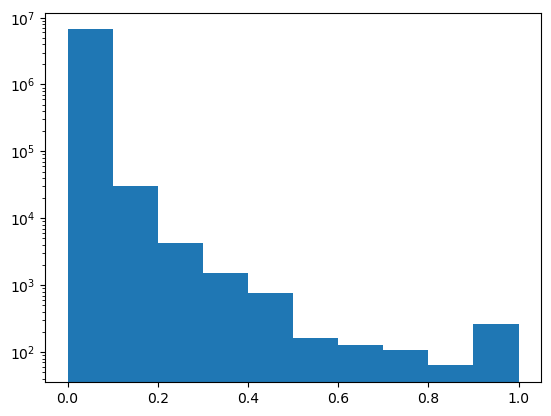

In [68]:
# histogram of connection strengths 
plt.hist(inprop.data)
plt.yscale('log')
plt.show()

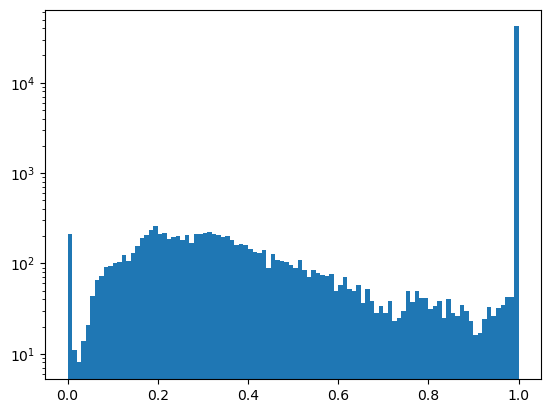

In [69]:
# histogram of column sums 
colsums = inprop.sum(axis=0)
plt.hist(colsums.A1, bins = 100)
plt.yscale('log')
plt.show()

In [70]:
sp.sparse.save_npz(
    'data/adult_inprop_cb_neuron_no_CX_axonic_postsynapses.npz', inprop)

In [71]:
# save to csv, one row is one neuron 
meta = cb[['root_id', 'combined_type', 'side', 'top_nt', 'super_class',
           'cell_class', 'cell_sub_class', 'ito_lee_hemilineage', 'hartenstein_hemilineage']]
meta.loc[:,['idx']] = meta.root_id.map(nodes_to_idx)
meta.loc[:, ['sign']] = meta.top_nt.map(nt_value)
meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)

# adult, right hemisphere, neuron level, meta information 
meta.to_csv(
    'data/adult_cb_neuron_meta_no_CX_axonic_postsynapses.csv')

C:\Users\44745\AppData\Local\Temp\ipykernel_128564\4112029996.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.rename(columns = {'combined_type': 'cell_type'}, inplace = True)


In [72]:
meta

,root_id,cell_type,side,top_nt,super_class,cell_class,cell_sub_class,ito_lee_hemilineage,hartenstein_hemilineage,idx,sign
0,720575940628857210,PS180,left,acetylcholine,central,NaN,NaN,SMPpv2_ventral,CP1_ventral,34118,1
1,720575940626838909,CB0924,right,acetylcholine,central,NaN,NaN,VLPl2_medial,BLAv2_medial,29863,1
2,720575940626046919,AVLP429,right,acetylcholine,central,NaN,NaN,NaN,NaN,28217,1
3,720575940630311383,AVLP151,right,acetylcholine,central,NaN,NaN,putative_primary,putative_primary,36983,1
4,720575940633370649,LC27,right,acetylcholine,visual_projection,NaN,NaN,NaN,NaN,41964,1
...,...,...,...,...,...,...,...,...,...,...,...
139250,720575940618571494,720575940618571494,right,acetylcholine,optic,ME>LO,NaN,NaN,NaN,13768,1
139251,720575940633170572,CB3823,right,acetylcholine,optic,LO,NaN,NaN,NaN,41634,1
139252,720575940650339961,CB3848,right,acetylcholine,optic,LO,NaN,NaN,NaN,50709,1
139253,720575940619997854,720575940619997854,left,acetylcholine,optic,ME>LO,NaN,NaN,NaN,16113,1
